## PDE Chase Model Solver
$$
\begin{align}
    \left\{\begin{array}{ll}
        \frac{\partial v}{\partial t}=\mu_V^2 \Delta_{\mathbf{x}} v +r_V(t, \mathbf{x}) v-\gamma_V V v - \rho(t,\mathbf{x})  v D, & \quad t>0,\,  \mathbf{x} \in \mathbb{R}^2, \\
         \frac{\partial d}{\partial t} = \mu_D^2 \Delta_{\mathbf{y}} d + r_D(t,\mathbf{y})d - \gamma_D \, {\frac{D}{V}}\, d + kv, & \quad t>0,\,  \mathbf{y}\in \mathbb{R}^2,
    \end{array}\right.
\end{align}

\\

\begin{align}
    r_V(t, \mathbf{x}) &= R_V - \alpha_V^2 \|\mathbf{x}\|^2 - \beta^2  \|\mathbf{x}-\overline{\mathbf{x}}(t)\|^2, \\
    \rho(t,\mathbf{x}) &= \rho_{\max} \, e^{-\, \theta \|\mathbf{x}-\overline{\mathbf{y}}(t)\|^2}, \\
    r_D(t,\mathbf{y}) &= R_D - \alpha_D^2 \|\mathbf{y}+ \ell \mathbf{u}-\overline{\mathbf{x}}(t)\|^2.
\end{align}
$$

Adapted from Alfaro et al. 2025

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2
import graph_functions as g

def dynlattice(t, QL, A, B, PHENOx, PHENOy, params):
    
    nx, ny = params['nx'], params['ny']
    dx, dy = params['dx'], params['dy']
    padded_nx = params['padded_nx']
    padded_ny = params['padded_ny']

    muH, muP, beta, gammaH, gammaP, rhomax_eff, alphaP_eff, RP, k, ell = (
        params["muH"], params["muP"], params["beta"], params["gammaH"], params["gammaP"],
        params["rhomax_eff"], params["alphaP_eff"], params["RP"], params["k"], params["ell"]
    )
    fft_K_target_padded = params['fft_K_target_padded']
    fft_K_virulence_padded = params['fft_K_virulence_padded']

    UH = QL[:nx * ny].reshape(ny, nx)
    UP = QL[nx * ny:].reshape(ny, nx)

    UH = np.maximum(UH, 0)
    UP = np.maximum(UP, 0)

    # 1. Create padded arrays and copy original data into the top-left corner
    UH_padded = np.zeros((padded_ny, padded_nx))
    UP_padded = np.zeros((padded_ny, padded_nx))
    UH_padded[:ny, :nx] = UH
    UP_padded[:ny, :nx] = UP

    # 2. Perform FFT on padded data
    fft_UH_padded = fft2(UH_padded)
    fft_UP_padded = fft2(UP_padded)

    # 3. Convolve in frequency domain
    fft_Targeting_padded = fft_K_target_padded * fft_UH_padded
    fft_Virulence_padded = fft_K_virulence_padded * fft_UP_padded

    # 4. Inverse FFT
    Targeting_padded = np.real(ifft2(fft_Targeting_padded))
    Virulence_padded = np.real(ifft2(fft_Virulence_padded))

    # 5. Extract the relevant ORIGINAL ny x nx portion
    Targeting_Matrix = Targeting_padded[:ny, :nx]
    Virulence_Matrix = Virulence_padded[:ny, :nx]

    MATrP = RP + alphaP_eff * Targeting_Matrix
    MATrhoP = rhomax_eff * Virulence_Matrix

    NH = np.sum(UH) * dx * dy # Total based on original grid
    NP = np.sum(UP) * dx * dy # Total based on original grid
    safe_NH = max(NH, 1e-12)

    xbarH = [0.0, 0.0]
    if NH > 1e-12:
        xbarH = [np.sum(PHENOx * UH) / safe_NH, np.sum(PHENOy * UH) / safe_NH]
    ag = lambda x, y: -beta * ((x - xbarH[0])**2 + (y - xbarH[1])**2)
    MATag = ag(PHENOx, PHENOy) # Evaluated on original PHENOx, PHENOy grid

    MATrH = params["rH"](PHENOx, PHENOy)

    # Diffusion (uses original A, B matrices which handle Neumann BCs)
    diff_H = muH * (UH @ A + B @ UH)
    diff_P = muP * (UP @ A + B @ UP)

    # Host Equation (using extracted Virulence_Matrix)
    dUHM = diff_H + MATrH * UH + MATag * UH - MATrhoP * UH - gammaH * UH * NH

    # Parasite Equation (using extracted Targeting_Matrix)
    dUPM = diff_P + MATrP * UP - gammaP * UP * NP + k * UH

    # Flatten results from ORIGINAL grid size
    return np.concatenate([dUHM.flatten(), dUPM.flatten()])

# Solver function adapted for FFT with PADDING
def sol_PDE_2D_circle_fft(params, initial_UH=None, initial_UP=None):
    """
    Solves the 2D host-parasite PDE system on a circular domain (phenotype space)
    using FFT for non-local interactions with padding to avoid wrap-around artifacts.
    Implements Neumann boundary conditions for diffusion.
    """
    default_params = {
        "alphaH": 0.1, "beta": 1, "rhomax": 0.1, "T": 25, "ell": 0, "k": 0.5,
        "posi0": 0.5, "muH": 0.1, "muP": 0.1, "RH": 4, "RP": 1, "N0": 5,
        "gammaH": 1, "gammaP": 1, "theta": 1, "alphaP": 1, "bord": 5, "nx": 100,
        "target_scale": 0.5, "virulence_scale": 0.5,
        "alphaP_eff": 1.0, "rhomax_eff": 0.1,
    }

    upd_params = default_params.copy()
    upd_params.update(params)

    nx = upd_params['nx']
    ny = nx
    bord = upd_params['bord']

    padded_nx = 2 * nx
    padded_ny = 2 * ny
    upd_params['padded_nx'] = padded_nx
    upd_params['padded_ny'] = padded_ny

    # Space setup (ORIGINAL grid)
    dx = dy = (2.0 * bord) / nx
    x_centers = np.linspace(-bord + dx/2.0, bord - dx/2.0, nx)
    y_centers = np.linspace(-bord + dy/2.0, bord - dy/2.0, ny)
    PHENOx, PHENOy = np.meshgrid(x_centers, y_centers)

    upd_params["rH"] = lambda x, y: upd_params["RH"] - upd_params["alphaH"] * (x**2 + y**2)
    upd_params.update({"dx": dx, "dy": dy, "nx": nx, "ny": ny})

    # Initial Conditions (on ORIGINAL grid)
    N0 = upd_params['N0']
    if initial_UH is not None and initial_UP is not None:
        # Ensure reshaping matches original grid size
        VH = initial_UH.reshape(ny, nx)
        VP = initial_UP.reshape(ny, nx)
    else:
        # Default initialization: place populations as localized peaks
        posi = upd_params["posi0"]
        VH = np.zeros((ny, nx))
        VP = np.zeros((ny, nx))
        # Find indices closest to desired starting positions
        ix_H = np.argmin(np.abs(x_centers - posi))
        iy_H = np.argmin(np.abs(y_centers - posi))
        ix_P = np.argmin(np.abs(x_centers - np.sqrt(2)*posi)) # Example different start for P
        iy_P = np.argmin(np.abs(y_centers - 0))
        # Set initial density at these points
        if dx > 0 and dy > 0:
            VH[iy_H, ix_H] = N0 / (dx * dy) # Density = Number / Area
            VP[iy_P, ix_P] = (N0 / 10) / (dx * dy)
        else: # Handle potential dx=0 or dy=0 case (though unlikely here)
             VH[iy_H, ix_H] = N0
             VP[iy_P, ix_P] = (N0/10)
        # Normalize total population size to desired N0
        VH = VH * N0 / max(1e-12, np.sum(VH) * dx * dy)
        VP = VP * (N0 / 10) / max(1e-12, np.sum(VP) * dx * dy)

    # Flatten initial conditions for the ODE solver
    Q0 = np.concatenate([VH.flatten(), VP.flatten()])

    # Diffusion matrices with Neumann BCs
    A = np.diag(np.ones(nx - 1), -1) - 2 * np.eye(nx) + np.diag(np.ones(nx - 1), 1)
    A[0, 0] = -2 # Correct diagonal element for BC
    A[0, 1] = 2  # Correct off-diagonal element for BC
    A[-1, -1] = -2 # Correct diagonal element
    A[-1, -2] = 2  # Correct off-diagonal element
    A /= dx**2     # Scale by grid spacing squared

    B = np.diag(np.ones(ny - 1), -1) - 2 * np.eye(ny) + np.diag(np.ones(ny - 1), 1)
    B[0, 0] = -2
    B[0, 1] = 2
    B[-1, -1] = -2
    B[-1, -2] = 2
    B /= dy**2

    upd_params['fft_K_target_padded'] = create_fft_kernel_padded(upd_params, 'target_scale', padded_nx, padded_ny)
    upd_params['fft_K_virulence_padded'] = create_fft_kernel_padded(upd_params, 'virulence_scale', padded_nx, padded_ny)

    # Solve the PDE system using an ODE solver
    T = upd_params['T']
    print(f"Starting ODE solver (RK45) for t=[0, {T}]...")
    sol = solve_ivp(
        # lambda function passes necessary variables to the dynamics function
        lambda t, Q: dynlattice(t, Q, A, B, PHENOx, PHENOy, upd_params),
        [0, T], # Time span
        Q0,     # Initial conditions
        method='RK45',
        rtol=1e-5, atol=1e-8 # Relative and absolute tolerances
    )
    print(f"Solver finished. Success: {sol.success}, Status: {sol.status}, Message: {sol.message}")

    # Extract results and reshape back to original grid dimensions
    tt, Y = sol.t, sol.y
    num_t_steps = len(tt)
    NH, NP = np.zeros(num_t_steps), np.zeros(num_t_steps) # Total populations over time
    xbarH, xbarP = np.zeros((num_t_steps, 2)), np.zeros((num_t_steps, 2)) # Mean phenotypes
    UHM3, UPM3 = np.zeros((ny, nx, num_t_steps)), np.zeros((ny, nx, num_t_steps)) # Full distributions

    print("Processing results...")
    for i in range(num_t_steps):
        # Extract solutions for this time step and reshape to original grid size
        UHM = Y[:nx * ny, i].reshape(ny, nx)
        UPM = Y[nx * ny:, i].reshape(ny, nx)
        UHM = np.maximum(UHM, 0) # Ensure non-negativity physically makes sense
        UPM = np.maximum(UPM, 0)

        UHM3[:, :, i], UPM3[:, :, i] = UHM, UPM # Store the 2D distribution
        NH[i] = np.sum(UHM) * dx * dy # Calculate total host population size
        NP[i] = np.sum(UPM) * dx * dy # Calculate total parasite population size

        # Calculate mean phenotype, handle potential division by zero if population is extinct
        safe_NH_i = max(NH[i], 1e-12)
        safe_NP_i = max(NP[i], 1e-12)

        xbarH[i, 0] = np.sum(PHENOx * UHM) / safe_NH_i
        xbarH[i, 1] = np.sum(PHENOy * UHM) / safe_NH_i
        xbarP[i, 0] = np.sum(PHENOx * UPM) / safe_NP_i
        xbarP[i, 1] = np.sum(PHENOy * UPM) / safe_NP_i

    print("Final host population size:", NH[-1])
    print("Final parasite population size:", NP[-1])

    # Return time points, raw solver output, mean phenotypes, grid info, full distributions, and total populations
    return tt, Y, xbarH, xbarP, nx, ny, x_centers, y_centers, PHENOx, PHENOy, UHM3, UPM3, NH, NP

# FFT kernel with padding to avoid spillover
def create_fft_kernel_padded(params, scale_param_name, padded_nx, padded_ny):
    # Creates a Gaussian interaction kernel on a padded grid and computes its FFT.
    dx, dy = params['dx'], params['dy']
    scale = params[scale_param_name]

    if scale <= 1e-9:
        print(f"Warning: {scale_param_name} is near zero. Using delta kernel (FFT=1).")
        return np.ones((padded_ny, padded_nx), dtype=complex) # FFT of delta is 1

    scale_sq = scale**2

    kx = np.fft.fftfreq(padded_nx, d=dx)
    ky = np.fft.fftfreq(padded_ny, d=dy)
    kxx, kyy = np.meshgrid(kx, ky)

    ix = np.arange(padded_nx)
    iy = np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)

    dx_sq = np.minimum(ixx, padded_nx - ixx)**2 * dx**2
    dy_sq = np.minimum(iyy, padded_ny - iyy)**2 * dy**2
    dist_sq_kernel = dx_sq + dy_sq

    # Gaussian kernel
    kernel = np.exp(-dist_sq_kernel / (2 * scale_sq))

    kernel_integral = np.sum(kernel) * dx * dy
    if kernel_integral > 1e-12:
        kernel /= kernel_integral
    else:
        print(f"Warning: Interaction kernel integral near zero for {scale_param_name}. Check scale.")
        kernel = np.zeros((padded_ny, padded_nx))
        # Place peak at (0,0) index
        kernel[0, 0] = 1.0 / (dx * dy)

    # Return the FFT of the kernel
    fft_K = fft2(kernel)
    return fft_K


Starting ODE solver (RK45) for t=[0, 50]...
Solver finished. Success: True, Status: 0, Message: The solver successfully reached the end of the integration interval.
Processing results...
Final host population size: 0.8125821818852725
Final parasite population size: 2.088474576190905


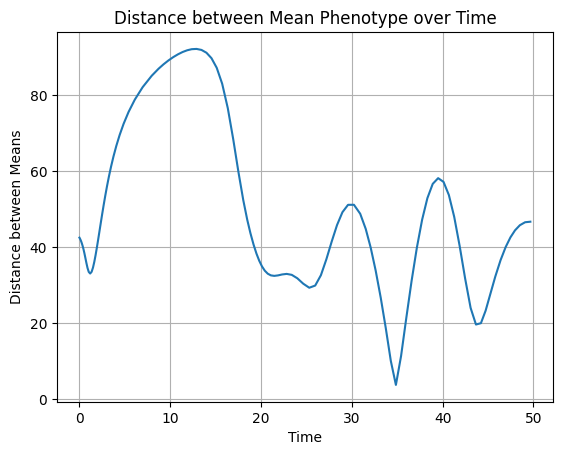

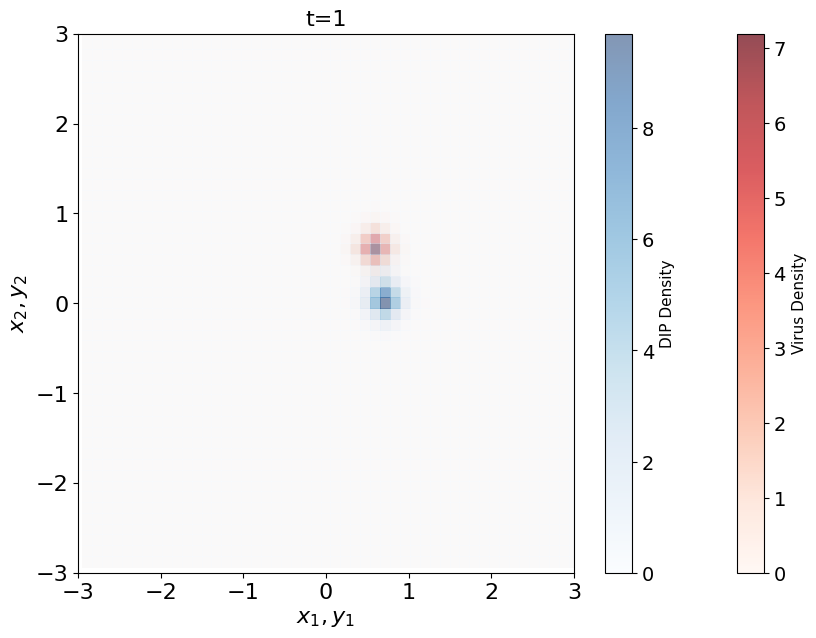

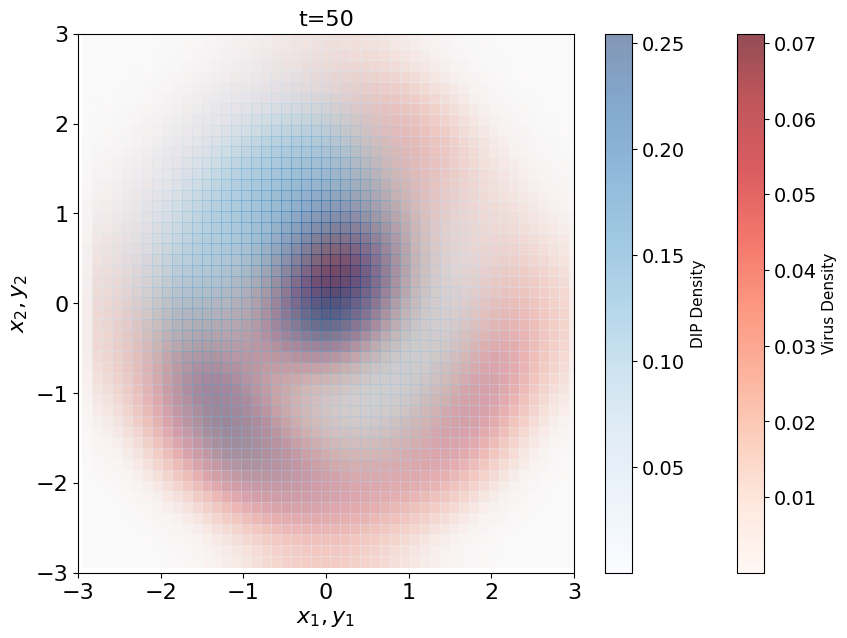

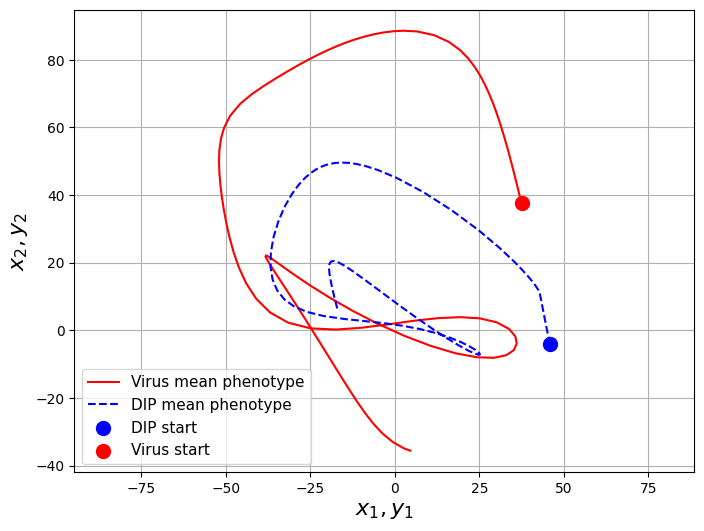

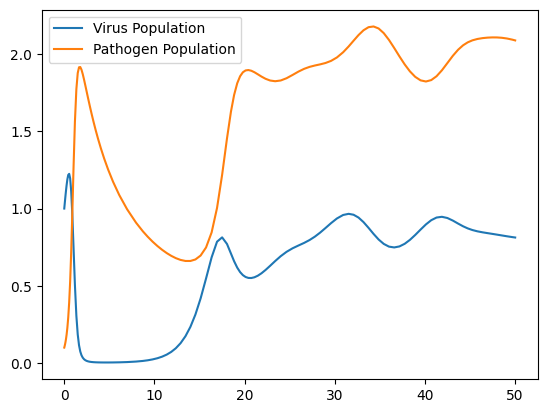

In [ ]:
nx = 50 # Resolution
bord = 3 # Border size
params = {
        "alphaH": 0.1, "beta": 0, "rhomax": 0.01, "T": 50, "ell": 0, "k": 0.01,
        "posi0": 0.5, "muH": 0.01, "muP": 0.01, "RH": 1, "RP": 0, "N0": 1,
        "gammaH": 0.1, "gammaP": 0.1, "theta": 1, "alphaP": 0.1, "bord": bord, "nx": nx,
        "target_scale": 0.5, "virulence_scale": 0.5, # FFT Parameters
        "alphaP_eff": 0.1, "rhomax_eff": 0.1, # Scaling for FFT
    }

tt, Y, xbarH, xbarP, nx, ny, x_centers, y_centers, PHENOx, PHENOy, UHM3, UPM3, NH, NP = sol_PDE_2D_circle_fft(params)

g.plot_mean_distance(xbarH, xbarP, tt, 50)
g.plot_combined_heatmaps_at_time_T(tt, UHM3, UPM3, nx, bord, 1, 'label')
g.plot_combined_heatmaps_at_time_T(tt, UHM3, UPM3, nx, bord, 50, 'label')
g.plot_mean_phenotypes(xbarH, xbarP, tt, 'label', mark_times=[])
g.plot_populations_vs_time(NH, NP, tt)
